In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

import warnings 
warnings.filterwarnings("ignore")

## Data

In [ ]:
df = pd.read_csv("sunspots.csv")
df["YEAR"] = pd.to_datetime(df["YEAR"],format="%Y")
df.info()

FileNotFoundError: ignored

In [ ]:
df.index = df["YEAR"]
del df["YEAR"]
df.head(5)

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


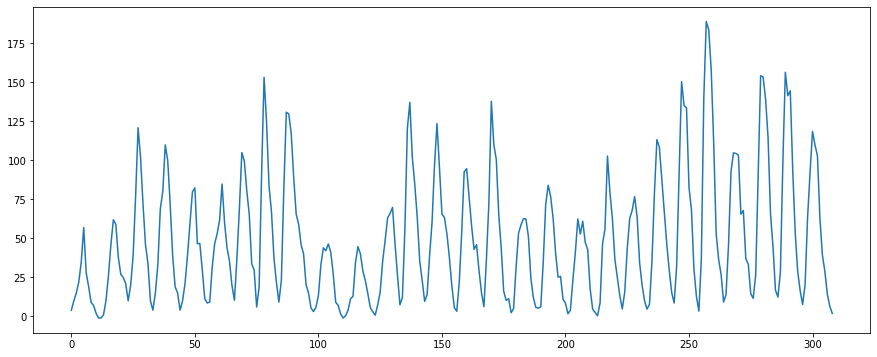

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(arr)
plt.show()

## ARMA

- ARMA has 3 Hyperparams 
  1. MA - p
  2. AR - q

We can find those using ACF (AutoCorrelation Factor) and 
PACF (Partial Autocorrelation Factor)

- Seasonal patterns of time series can be examined via correlograms, which display graphically and numerically the autocorrelation function (ACF)
- (PACF) – an extension of autocorrelation, where the dependence on the intermediate elements (those within the lag) is removed

<b> Removing serial dependency </b><br>
Serial dependency for a particular lag can be removed by differencing the series. This makes time series stationary

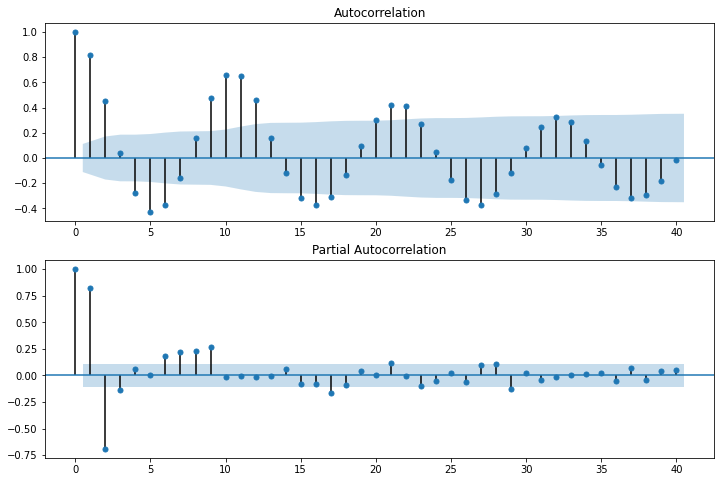

In [ ]:
# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)
plt.show()

In [ ]:
# (1,2) = (p,q)
arma_mod20 = sm.tsa.ARMA(df['SUNACTIVITY'], (1,2)).fit()
print(arma_mod20.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


const                49.073216
ar.L1.SUNACTIVITY     0.602536
ma.L1.SUNACTIVITY     0.760355
ma.L2.SUNACTIVITY     0.433252
dtype: float64


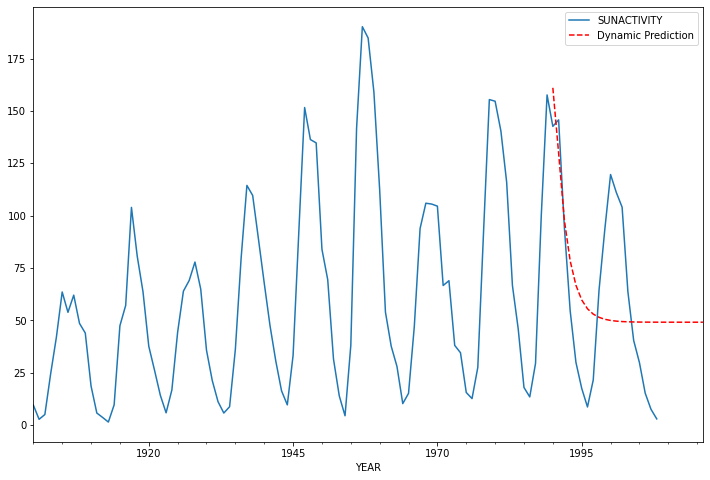

In [ ]:
predict_sunspots20 = arma_mod20.predict('1990', '2016', dynamic=True)

df.loc['1900':].plot(figsize=(12,8))
predict_sunspots20.plot(style='r--', label='Dynamic Prediction');
plt.legend();
plt.show()

## ARIMA

ARMA has 3 Hyperparams
1. MA - p
2. I - d
3. AR - q

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
train_df = df.iloc[:280,]
test_df = df.iloc[280:,]
print(train_df.shape, test_df.shape)

(280, 1) (29, 1)


In [ ]:
arima= ARIMA(train_df['SUNACTIVITY'],order=(2,0,3)).fit()
print(arima.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


const                48.202527
ar.L1.SUNACTIVITY     1.429317
ar.L2.SUNACTIVITY    -0.729654
ma.L1.SUNACTIVITY    -0.095365
ma.L2.SUNACTIVITY     0.064777
ma.L3.SUNACTIVITY    -0.031883
dtype: float64


In [ ]:
# steps = predict next (steps) values from last train date
arima_preds = arima.forecast(steps=29)[0]
pred_df = test_df.copy()
pred_df = pred_df.iloc[:len(arima_preds),:]
pred_df["SUNACTIVITY"] = arima_preds

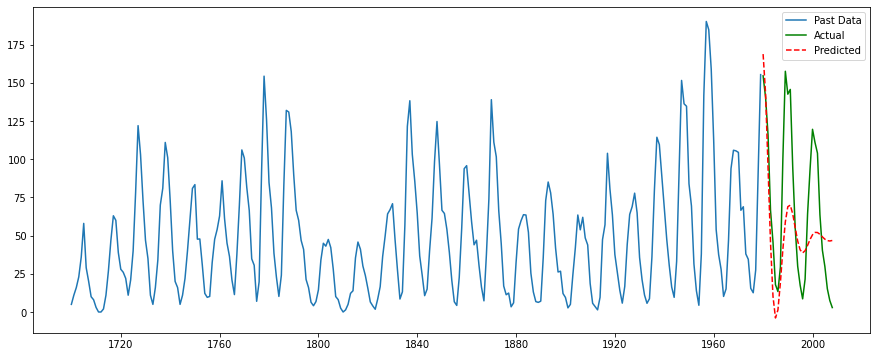

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_df["SUNACTIVITY"])
plt.plot(test_df["SUNACTIVITY"],'g')
plt.plot(pred_df["SUNACTIVITY"],'r--')
plt.legend(["Past Data","Actual","Predicted"])
plt.show()

## Auto ARIMA
Find p,d,q automatically

## FB Prophet

In [ ]:
# pip install fbprophet
# check prophet version
from fbprophet import Prophet

In [ ]:
df_fb = df.copy()
df_fb["y"] = df_fb["SUNACTIVITY"]
df_fb['ds'] = df_fb.index
train_df = df_fb.iloc[:280,]
test_df = df_fb.iloc[280:,]
print(train_df.shape, test_df.shape)

(280, 3) (29, 3)


In [ ]:
fb_model = Prophet()
fb_model.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_dates = fb_model.make_future_dataframe(periods=29) # periods = days
fb_preds = fb_model.predict(future_dates)
fb_preds.head(2)
# pred = yhat, bounds = [y_hat_upper,y_hat_lower]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1979-01-31,86.697117,0.411923,97.274198,86.697117,86.697117,-39.270813,-39.270813,-39.270813,-39.270813,-39.270813,-39.270813,0.0,0.0,0.0,47.426303
1,1979-02-28,86.719076,61.974228,159.611787,86.719076,86.719076,22.742497,22.742497,22.742497,22.742497,22.742497,22.742497,0.0,0.0,0.0,109.461573


In [ ]:
pred_dates = pd.DataFrame({"ds":test_df.index})
pred_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      29 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 360.0 bytes


In [ ]:
pred_df = test_df.copy()
pred_df["preds"] = fb_preds.iloc[-29:]["yhat"].values

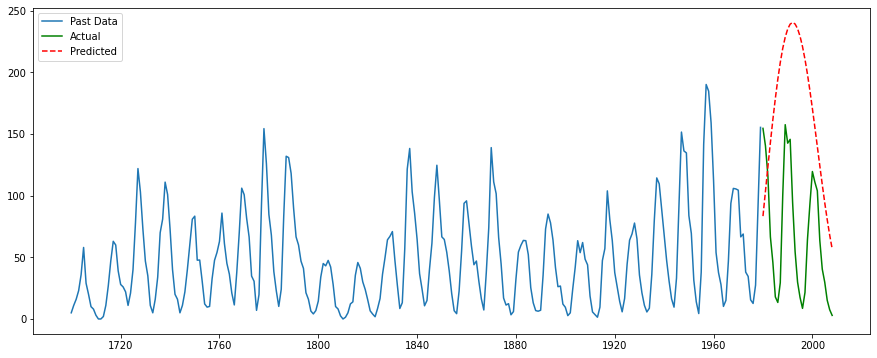

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_df["y"])
plt.plot(test_df["y"],'g')
plt.plot(pred_df["preds"],'r--')
plt.legend(["Past Data","Actual","Predicted"])
plt.show()

# LSTM -> MultiVariate

## Data

Predict power usage -> "Applicances"
Contains data collected every 10 minutes

In [81]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")
df["temperature"] = df["T1"]+df["T2"]+df["T3"]+df["T4"]+df["T5"]+df["T6"]+df["T7"]+df["T8"]
df["humidity"] = df["RH_1"]+df["RH_2"]+df["RH_3"]+df["RH_4"]+df["RH_5"]+df["RH_6"]+df["RH_7"]+df["RH_8"]
df["date"] = pd.to_datetime(df["date"],infer_datetime_format=True)
df_index = df["date"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

In [82]:
df_data = df[["humidity","temperature","lights","Appliances"]].copy()
df_data.index = df["date"]

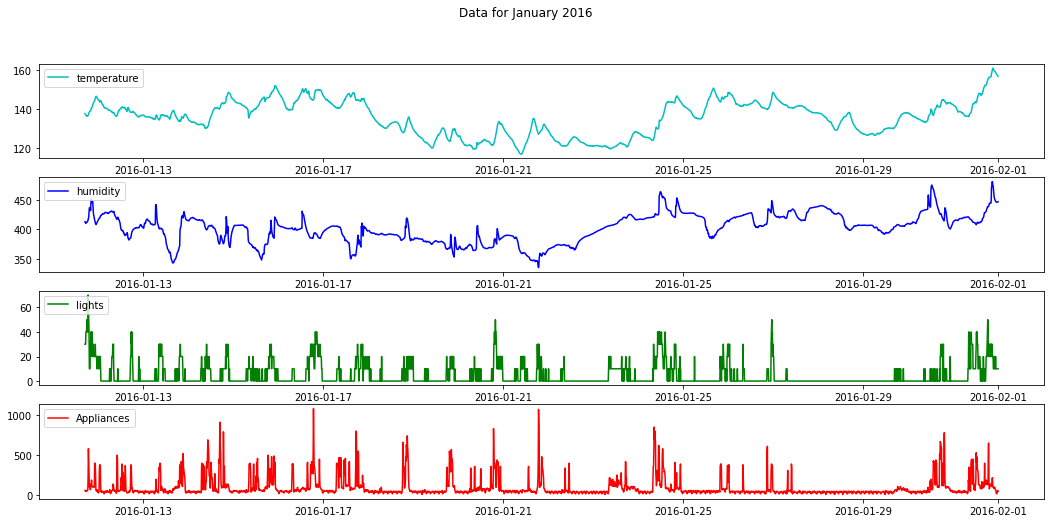

In [83]:
df_input = df_data.loc['2016-01-01':'2016-01-31']
fig, ax = plt.subplots(4,1,figsize=(18,8))
ax[0].plot(df_input["temperature"],'c',label="temperature")
ax[0].legend(loc='upper left')
ax[1].plot(df_input["humidity"],'b',label="humidity")
ax[1].legend(loc='upper left')
ax[2].plot(df_input["lights"],'g',label="lights")
ax[2].legend(loc='upper left')
ax[3].plot(df_input["Appliances"],'r',label="Appliances")
ax[3].legend(loc='upper left')
fig.suptitle("Data for January 2016")
plt.show()

In [84]:
df_input = df_data.copy()

## Data Preparation

Here we have two options
1. predict appliances using other data from previous steps
2. Predict appliances using other data + appliances from older steps
  - Problems : to pred[10] <br>
      ( you need to have older data + appliances values)
      -> pred[0] + data[0] -> pred[1] <br>
      -> pred[1] + data[1] -> pred[2] <br>
      -> -> -> -> pred[9] + data[9] -> pred[10]

In [85]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler

In [86]:
scaler = StandardScaler()
scaler.fit(df_data)
print(df_data.head(2))
print()

df_data = scaler.transform(df_data)
print(df_data[0])

                       humidity  temperature  lights  Appliances
date                                                            
2016-01-11 17:00:00  412.666667   137.473333      30          60
2016-01-11 17:10:00  411.885000   137.280000      30          60

[ 1.37985475 -1.00175638  3.30126384 -0.36767572]


In [87]:
X_train, X_test, y_train, y_test = train_test_split(df_data,df_data[:,-1],shuffle=False)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_train[:4])

# to predict appliances[3] -> we use [humidity  temperature  lights  Appliances] from [0] and [1]

(14801, 4) (14801,)
(4934, 4) (4934,)
[[ 1.37985475 -1.00175638  3.30126384 -0.36767572]
 [ 1.36440982 -1.01283818  3.30126384 -0.36767572]
 [ 1.33032561 -1.03270899  3.30126384 -0.46521548]
 [ 1.32268548 -1.05162448  4.56137838 -0.46521548]]


In [88]:
TimeseriesGenerator(X_train, y_train, length = 3, sampling_rate=1, batch_size=1)[0]

(array([[[ 1.37985475, -1.00175638,  3.30126384, -0.36767572],
         [ 1.36440982, -1.01283818,  3.30126384, -0.36767572],
         [ 1.33032561, -1.03270899,  3.30126384, -0.46521548]]]),
 array([-0.46521548]))

In [89]:
n_features = 4
batch_size = 32
window_length = 36

train_gen = TimeseriesGenerator(X_train, y_train, length = window_length, sampling_rate=1, batch_size=batch_size)
test_gen = TimeseriesGenerator(X_test, y_test, length = window_length, sampling_rate=1, batch_size=batch_size)

## Modelling

In [90]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, LSTM, LeakyReLU, Dropout

In [91]:
input = Input(shape=(window_length, n_features))
x = LSTM(128, return_sequences=True)(input)
x = LeakyReLU()(x)
x = LSTM(64, return_sequences=True)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = LSTM(48, return_sequences=False)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

In [92]:
model = Model(inputs=input, outputs=output)

In [93]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 36, 4)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 36, 128)           68096     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 36, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 36, 64)            49408     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 36, 64)            0         
                                                                 
 dropout_4 (Dropout)         (None, 36, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 48)                2169

In [94]:
model.compile(
    loss = tf.losses.MeanSquaredError(),
    optimizer = 'adam',
    metrics = [tf.losses.MeanAbsoluteError()]
)

In [98]:
model.fit_generator(
    train_gen,
    epochs = 10,
    shuffle = False,
    validation_data = test_gen
)

Epoch 1/10
  3/462 [..............................] - ETA: 14s - loss: 0.7816 - mean_absolute_error: 0.6882

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


462/462 [==============================] - 16s 35ms/step - loss: 0.7217 - mean_absolute_error: 0.5528 - val_loss: 0.5093 - val_mean_absolute_error: 0.4705
Epoch 2/10
462/462 [==============================] - 17s 37ms/step - loss: 0.7248 - mean_absolute_error: 0.5546 - val_loss: 0.5068 - val_mean_absolute_error: 0.4641
Epoch 3/10
462/462 [==============================] - 16s 35ms/step - loss: 0.7212 - mean_absolute_error: 0.5528 - val_loss: 0.5082 - val_mean_absolute_error: 0.4674
Epoch 4/10
462/462 [==============================] - 16s 35ms/step - loss: 0.7189 - mean_absolute_error: 0.5522 - val_loss: 0.5083 - val_mean_absolute_error: 0.4625
Epoch 5/10
462/462 [==============================] - 16s 35ms/step - loss: 0.7200 - mean_absolute_error: 0.5526 - val_loss: 0.5067 - val_mean_absolute_error: 0.4662
Epoch 6/10
462/462 [==============================] - 16s 35ms/step - loss: 0.7179 - mean_absolute_error: 0.5513 - val_loss: 0.5105 - val_mean_absolute_error: 0.4731
Epoch 7/10
462/

In [99]:
model.evaluate(test_gen)

154/154 [==============================] - 2s 14ms/step - loss: 0.5127 - mean_absolute_error: 0.4716


[0.5126503109931946, 0.47158926725387573]

## Test Predictions

In [129]:
test_data = TimeseriesGenerator(X_test, y_test, length = window_length, sampling_rate=1, batch_size=1)
y_preds = []
for x,y in test_data:
  pred = model.predict(x)
  pred = scaler.inverse_transform([[0,0,0,pred]])[0][-1]
  true = scaler.inverse_transform([[0,0,0,y[0]]])[0][-1]
  y_preds.append((true,pred))

[]

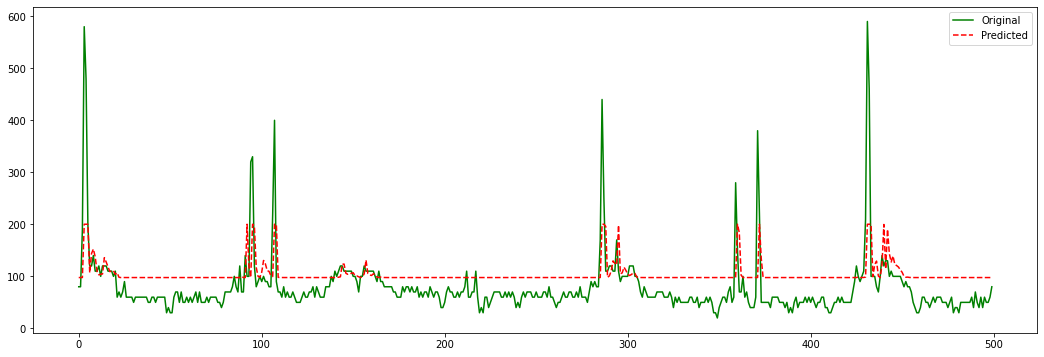

In [137]:
preds = y_preds[:500]
plt.figure(figsize=(18,6))
plt.plot([x[0] for x in preds],'g')
plt.plot([x[1] for x in preds],'r--')
plt.legend(["Original", "Predicted"])
plt.plot()

[]

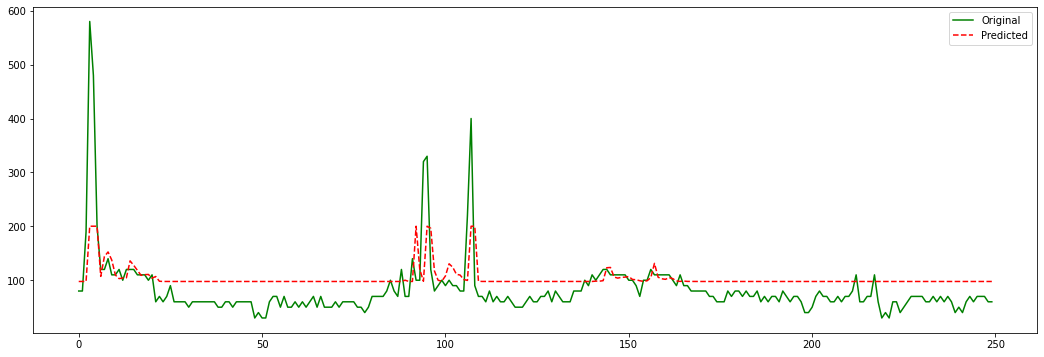

In [138]:
preds = y_preds[:250]
plt.figure(figsize=(18,6))
plt.plot([x[0] for x in preds],'g')
plt.plot([x[1] for x in preds],'r--')
plt.legend(["Original", "Predicted"])
plt.plot()

[]

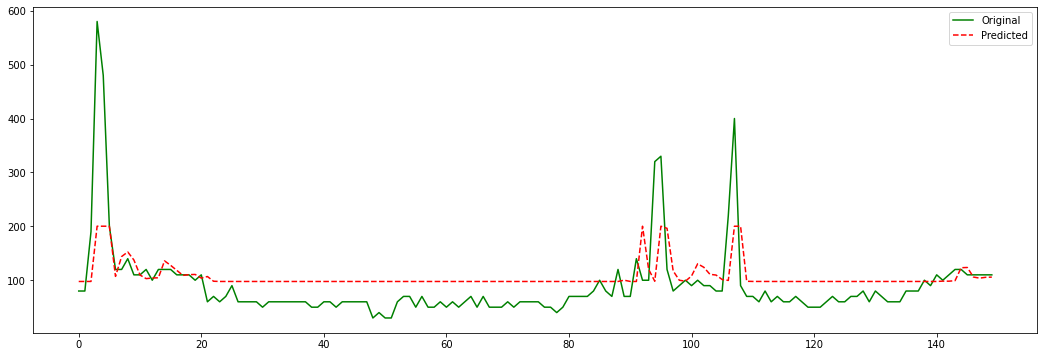

In [140]:
preds = y_preds[:150]
plt.figure(figsize=(18,6))
plt.plot([x[0] for x in preds],'g')
plt.plot([x[1] for x in preds],'r--')
plt.legend(["Original", "Predicted"])
plt.plot()